# Time-Weighted Average Price (TWAP) v1

## Parameters
Parameters: &lt;side&gt; &lt;quantity&gt; [limit_px] 

side = "b" (buy) or "s" (sell)

quantity = # of shares

limit_px = limit price (optional)

### Structure
1. Get market data
1. Read order parameters 
1. Calculate shares per bin to execute
1. Initiate loop (reading market data)
    1. Read each n bins of data
    1. Record a trade at the bin price (last for now)
    1. Accumulate the trade per bin
1. Calculate and plot summary statistics (average price, slippage vs. vwap, vs. arrival, vs. interval vwap

In [17]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%run getstock.py

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [12]:
# get our market data, plot it to sanity check
bars = getMinuteStockPrices('AAPL')
day = bars['2019-09-18']

In [13]:
day.head()

,open,high,low,close,volume
timestamp,,,,,
2019-09-18 09:31:00,221.0182,221.4873,220.8868,221.1482,646811
2019-09-18 09:32:00,221.1100,221.1100,220.9600,220.9600,111530
2019-09-18 09:33:00,221.0300,221.0300,220.9200,220.9200,85929
2019-09-18 09:34:00,220.9400,221.5000,220.9400,221.5000,227425
2019-09-18 09:35:00,221.4500,221.5500,221.4500,221.5300,153545


## Time-Weighted Average Price (TWAP) v1.0

In [14]:
# order parameters
# order quantity in shares
quantity = 1000000

# initialize some counters
quantity_remaining = quantity
trades = pd.DataFrame( columns = [ 'price' , 'shares'], index=day.index )

# v1.0 
# assume this is a full day order
# use 1 minute bins
n_bins = 390
slice_size = quantity / n_bins

# main event loop
for index, row in day.iterrows() :
    # Read each bin of data
    px = ( row['high'] + row['low'] ) / 2 # calculate midpoint of that bar
    volume = row[ 'volume' ]
    
    # Calculate % of volume and bin price (last for now)
    new_trade = slice_size
    
    # Accumulate the trade per bin
    trades.loc[index] = [ px, new_trade ]
    
    # decrement the remaining qty, and bail out if it's zero
    quantity_remaining -= new_trade
    
    # debug
    #print( str(volume) + " " + str(new_trade) + " " + str(quantity_remaining) )
    
    if ( quantity_remaining <= 0 ):
        break

In [15]:
trades['shares'].sum()

1000000.0000000102

### Performance Analysis of TWAP

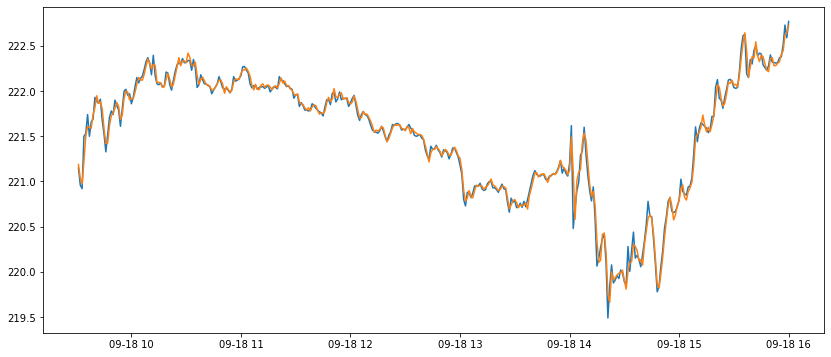

In [19]:
trade_results = pd.DataFrame(index = day.index)
trade_results['mkt_px'] = pd.Series(day['close'])
trade_results['trade_px'] = pd.Series(trades['price'])
plt.plot( trade_results )
plt.show()

### Summary Stats of TWAP Order

In [22]:
# average trade price
pavg = ( trades['price'] * trades['shares'] ).sum() /  trades['shares'].sum()

# calculate VWAP
vwap = ( day['close'] * day['volume'] ).sum() / day['volume'].sum()

slippage =  ( ( vwap - pavg ) / vwap ) * 10000

print( "Avg Price: {:.4f}".format(pavg) )
print( "VWAP: {:.4f}".format(vwap) )
print( "Performance vs Day VWAP in bps: {:.4f}".format(slippage) )

Avg Price: 221.5123
VWAP: 221.5119
Performance vs Day VWAP in bps: -0.0178


### Improvements
* Support Limit Price
* better price simulation
* change trade ahead percent based on price (buy slightly more when low, slightly less when high?)
* tick data!